In [12]:
!pip install /kaggle/input/bitsandbytes-pip-download/bitsandbytes-0.43.1-py3-none-manylinux_2_24_x86_64.whl -q
!pip install /kaggle/input/accelerate-pip-download/accelerate-0.30.1-py3-none-any.whl -q
!pip install --no-index --find-links=/kaggle/input/install-peft peft -q

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/kaggle/input/bitsandbytes-pip-download/bitsandbytes-0.43.1-py3-none-manylinux_2_24_x86_64.whl'

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/kaggle/input/accelerate-pip-download/accelerate-0.30.1-py3-none-any.whl'

ERROR: Could not find a version that satisfies the requirement nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64" (from torch) (from versions: none)
ERROR: No matching distribution found for nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64"


In [1]:
!pip install -U bitsandbytes accelerate peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 32.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.1 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

In [2]:
import os
import gc
import pandas as pd
import numpy as np
from tqdm import tqdm

from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModel, AutoModelForCausalLM

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from torch.amp import GradScaler, autocast

from peft import (
    get_peft_config, 
    get_peft_model, 
    LoraConfig,
    TaskType,
     prepare_model_for_kbit_training
)

from transformers import BitsAndBytesConfig
from transformers import get_cosine_schedule_with_warmup

from sentence_transformers import SentenceTransformer
from peft import AutoPeftModelForFeatureExtraction

import ctypes
import os

from threading import Thread
from tqdm.notebook import tqdm

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

2025-05-12 08:29:52.211660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747038592.456555      73 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747038592.526532      73 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def clean_memory(deep=True):
    gc.collect()
    if deep:
        ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()

In [4]:
test = pd.read_csv('/kaggle/input/classification-of-math-problems-by-kasut-academy/test.csv')

In [5]:
test.columns = ['id', 'problem']

prompts = [
    f"""'<|im_start|>user
Your task is to classify each Math problem into one of these eight topics using a machine learning or NLP-based approach.
0: Algebra
1: Geometry and Trigonometry
2: Calculus and Analysis
3: Probability and Statistics
4: Number Theory
5: Combinatorics and Discrete Math
6: Linear Algebra
7: Abstract Algebra and Topology

Your answer should be an integer that assigns the most appropriate topic category to the given Math problem based on its content and required reasoning.

Math Problem: {p.strip()}

Answer: """
    for p in test['problem']
]

test['problem'] = prompts
test['target'] = -100
test

,id,problem,target
0,0,'<|im_start|>user\nYour task is to classify ea...,-100
1,1,'<|im_start|>user\nYour task is to classify ea...,-100
2,2,'<|im_start|>user\nYour task is to classify ea...,-100
3,3,'<|im_start|>user\nYour task is to classify ea...,-100
4,4,'<|im_start|>user\nYour task is to classify ea...,-100
...,...,...,...
3039,3039,'<|im_start|>user\nYour task is to classify ea...,-100
3040,3040,'<|im_start|>user\nYour task is to classify ea...,-100
3041,3041,'<|im_start|>user\nYour task is to classify ea...,-100
3042,3042,'<|im_start|>user\nYour task is to classify ea...,-100


In [6]:
model_path = '/kaggle/input/qwen-3/transformers/14b/1'


tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.padding_side = 'left'

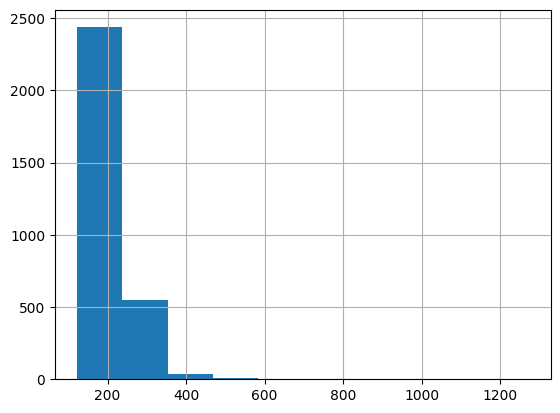

In [7]:
test['problem'].apply(lambda x:len( tokenizer(x).input_ids)).hist();

In [8]:
class MathDataset(Dataset):
    def __init__(self, prompts, targets):
        self.prompts = prompts  # 输入：题目（字符串数组）
        self.targets = targets  # 标签：对应分类标签（int数组）

    def __getitem__(self, idx):
        # 支持通过索引访问第 idx 条样本
        return self.prompts[idx], self.targets[idx]

    def __len__(self):
        # 数据集长度（总样本数）
        return len(self.targets)
        
# Split the test set into 4 parts
# 获取测试集总长度
length = len(test)

# 按 4 份平均划分（每份大小）
split_size = length // 4

# Create dataloaders for each GPU
test_datasets = []
test_dataloaders = []

for i in range(4):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < 3 else length  # 最后一块可能包含余数

    # 构造数据集（MathDataset 是我们上面定义的类）
    dataset = MathDataset(
        prompts=test['problem'].iloc[start_idx:end_idx].to_numpy(),
        targets=test['target'].iloc[start_idx:end_idx].to_numpy()
    )
    
    # 构造 DataLoader，batch_size=1（逐条推理），不打乱顺序
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        drop_last=False
    )
    
    # 存入列表中备用
    test_dataloaders.append(dataloader)

In [9]:
def get_preds(model, tokenizer, test_dataloader, device, results):
    # 初始化预测结果容器
    y_pred = torch.tensor([])  # 存储预测 logits
    y_true = torch.tensor([])  # （未使用，可删）

    with torch.no_grad():  # 禁用梯度计算（节省显存）
        model.eval()  # 切换到评估模式

        # 遍历测试集 DataLoader
        for batch_idx, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            batch_prompts, batch_targets = batch  # 解包：输入和目标

            # 编码文本，转为张量，移动到指定设备
            encodings = tokenizer(batch_prompts, return_tensors='pt', padding=True, truncation=True, max_length=400).to(device)

            batch_targets = batch_targets.long().to(device)  # 转换目标为 long 类型（未使用）

            # 启用自动混合精度以加速推理
            with autocast(device_type=device):
                logits = model(encodings)  # 得到模型输出（logits）

                y_pred = torch.cat([y_pred, logits.cpu()])  # 将当前 batch 结果拼接进总结果

    # 将当前设备上的预测结果存入共享结果字典
    results[device] = y_pred


In [10]:
class Net(nn.Module):
    def __init__(self, base_model_path, trained_backbone_path, load_in_device):
        super(Net, self).__init__()

        # 加载模型配置（例如 hidden_size）
        self.config = AutoConfig.from_pretrained(base_model_path)

        # 配置 bitsandbytes 的 4-bit 量化加载参数
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,                      # 启用 4-bit 权重量化
            bnb_4bit_use_double_quant=True,         # 启用双重量化
            bnb_4bit_quant_type="nf4",              # 使用 nf4 量化类型
            bnb_4bit_compute_dtype=torch.float16    # 推理使用 float16 精度
        )

        # 加载训练好的 backbone 模型（含 LoRA 权重），支持特征抽取任务
        self.backbone = AutoPeftModelForFeatureExtraction.from_pretrained(
            trained_backbone_path,                  # 已微调的模型路径
            use_cache=False,                        # 不启用缓存（节省显存）
            torch_dtype=torch.float16,              # 模型加载为 fp16
            quantization_config=bnb_config,         # 使用 4-bit 配置
            device_map=load_in_device               # 指定加载到的 GPU 设备
        )

        # 定义分类头（8 类），输入维度为模型的 hidden_size
        self.head = nn.Linear(self.config.hidden_size, 8, bias=False)

    def forward(self, x):
        # 获取最后一个 token 的隐藏状态向量（作为句子表示）
        x = self.backbone(**x).last_hidden_state[:, -1, :]

        # 送入分类头，输出 8 维 logits
        return self.head(x)


In [11]:
# 14b-qwen3-fold-1
trained_backbone_path = '/kaggle/input/best-fold-0-backbone'
trained_head_path = '/kaggle/input/best-fold-0-head/head_fold_0_best.pt'

model_1 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:0')

model_2 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:1')

model_3 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:2')

model_4 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:3')

model_1.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_2.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_3.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_4.head.load_state_dict(torch.load(trained_head_path, weights_only=True))

model_1.head.to('cuda:0')
model_2.head.to('cuda:1')
model_3.head.to('cuda:2')
model_4.head.to('cuda:3')

results = {}

t0 = Thread(target=get_preds, args=(model_1, tokenizer, test_dataloaders[0], 'cuda:0', results))
t1 = Thread(target=get_preds, args=(model_2, tokenizer, test_dataloaders[1], 'cuda:1', results))
t2 = Thread(target=get_preds, args=(model_3, tokenizer, test_dataloaders[2], 'cuda:2', results))
t3 = Thread(target=get_preds, args=(model_4, tokenizer, test_dataloaders[3], 'cuda:3', results))

t0.start()
t1.start()
t2.start()
t3.start()

t0.join()
t1.join()
t2.join()
t3.join()

logits_fold_1 = torch.cat([results['cuda:0'], results['cuda:1'], results['cuda:2'], results['cuda:3']])
pred_probs_fold_1 = F.softmax(logits_fold_1, dim=-1)

del model_1, model_2, model_3, model_4
clean_memory()

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

In [12]:
# 14b-qwen3 fold-2
trained_backbone_path = '/kaggle/input/best-fold-1-backbone'
trained_head_path = '/kaggle/input/best-fold-1-head/head_fold_1_best.pt'

model_1 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:0')

model_2 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:1')

model_3 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:2')

model_4 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:3')

model_1.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_2.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_3.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_4.head.load_state_dict(torch.load(trained_head_path, weights_only=True))

model_1.head.to('cuda:0')
model_2.head.to('cuda:1')
model_3.head.to('cuda:2')
model_4.head.to('cuda:3')

results = {}

t0 = Thread(target=get_preds, args=(model_1, tokenizer, test_dataloaders[0], 'cuda:0', results))
t1 = Thread(target=get_preds, args=(model_2, tokenizer, test_dataloaders[1], 'cuda:1', results))
t2 = Thread(target=get_preds, args=(model_3, tokenizer, test_dataloaders[2], 'cuda:2', results))
t3 = Thread(target=get_preds, args=(model_4, tokenizer, test_dataloaders[3], 'cuda:3', results))

t0.start()
t1.start()
t2.start()
t3.start()

t0.join()
t1.join()
t2.join()
t3.join()

logits_fold_2 = torch.cat([results['cuda:0'], results['cuda:1'], results['cuda:2'], results['cuda:3']])
pred_probs_fold_2 = F.softmax(logits_fold_2, dim=-1)

del model_1, model_2, model_3, model_4
clean_memory()

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

In [13]:
# 14b-qwen 3 fold-3
trained_backbone_path = '/kaggle/input/best-fold-2-backbone'
trained_head_path = '/kaggle/input/best-fold-2-head/head_fold_2_best.pt'

model_1 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:0')

model_2 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:1')

model_3 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:2')

model_4 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:3')

model_1.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_2.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_3.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_4.head.load_state_dict(torch.load(trained_head_path, weights_only=True))

model_1.head.to('cuda:0')
model_2.head.to('cuda:1')
model_3.head.to('cuda:2')
model_4.head.to('cuda:3')

results = {}

t0 = Thread(target=get_preds, args=(model_1, tokenizer, test_dataloaders[0], 'cuda:0', results))
t1 = Thread(target=get_preds, args=(model_2, tokenizer, test_dataloaders[1], 'cuda:1', results))
t2 = Thread(target=get_preds, args=(model_3, tokenizer, test_dataloaders[2], 'cuda:2', results))
t3 = Thread(target=get_preds, args=(model_4, tokenizer, test_dataloaders[3], 'cuda:3', results))

t0.start()
t1.start()
t2.start()
t3.start()

t0.join()
t1.join()
t2.join()
t3.join()

logits_fold_3 = torch.cat([results['cuda:0'], results['cuda:1'], results['cuda:2'], results['cuda:3']])
pred_probs_fold_3 = F.softmax(logits_fold_3, dim=-1)

del model_1, model_2, model_3, model_4
clean_memory()

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

In [14]:
pred_probs_qwen3_14b = (pred_probs_fold_1 + pred_probs_fold_2 + pred_probs_fold_3) / 3

In [15]:
df_1 = pd.DataFrame(pred_probs_fold_1.argmax(-1).tolist(), columns=['3fold_1'])
df_1['3fold_2'] = pred_probs_fold_2.argmax(-1).tolist()
df_1['3fold_3'] = pred_probs_fold_3.argmax(-1).tolist()
df_1

,3fold_1,3fold_2,3fold_3
0,0,0,0
1,4,4,4
2,0,2,0
3,4,4,4
4,4,4,4
...,...,...,...
3039,4,4,4
3040,1,1,1
3041,1,1,1
3042,4,4,4


In [16]:
model_path = '/kaggle/input/qwen2.5/transformers/14b/1'


tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.padding_side = 'left'

In [17]:
# 14b-qwen2.5 fold-1
trained_backbone_path = '/kaggle/input/qwen2-5-best-fold-0-backbone'
trained_head_path = '/kaggle/input/qwen2-5-best-fold-0-head/head_fold_0_best.pt'

model_1 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:0')

model_2 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:1')

model_3 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:2')

model_4 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:3')

model_1.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_2.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_3.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_4.head.load_state_dict(torch.load(trained_head_path, weights_only=True))

model_1.head.to('cuda:0')
model_2.head.to('cuda:1')
model_3.head.to('cuda:2')
model_4.head.to('cuda:3')

results = {}

t0 = Thread(target=get_preds, args=(model_1, tokenizer, test_dataloaders[0], 'cuda:0', results))
t1 = Thread(target=get_preds, args=(model_2, tokenizer, test_dataloaders[1], 'cuda:1', results))
t2 = Thread(target=get_preds, args=(model_3, tokenizer, test_dataloaders[2], 'cuda:2', results))
t3 = Thread(target=get_preds, args=(model_4, tokenizer, test_dataloaders[3], 'cuda:3', results))

t0.start()
t1.start()
t2.start()
t3.start()

t0.join()
t1.join()
t2.join()
t3.join()

logits_fold_1 = torch.cat([results['cuda:0'], results['cuda:1'], results['cuda:2'], results['cuda:3']])
pred_probs_fold_1 = F.softmax(logits_fold_1, dim=-1)

del model_1, model_2, model_3, model_4
clean_memory()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

In [18]:
# 14b-qwen2.5 fold-2
trained_backbone_path = '/kaggle/input/qwen2-5-best-fold-1-backbone'
trained_head_path = '/kaggle/input/qwen2-5-best-fold-1-head/head_fold_1_best.pt'

model_1 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:0')

model_2 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:1')

model_3 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:2')

model_4 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:3')

model_1.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_2.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_3.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_4.head.load_state_dict(torch.load(trained_head_path, weights_only=True))

model_1.head.to('cuda:0')
model_2.head.to('cuda:1')
model_3.head.to('cuda:2')
model_4.head.to('cuda:3')

results = {}

t0 = Thread(target=get_preds, args=(model_1, tokenizer, test_dataloaders[0], 'cuda:0', results))
t1 = Thread(target=get_preds, args=(model_2, tokenizer, test_dataloaders[1], 'cuda:1', results))
t2 = Thread(target=get_preds, args=(model_3, tokenizer, test_dataloaders[2], 'cuda:2', results))
t3 = Thread(target=get_preds, args=(model_4, tokenizer, test_dataloaders[3], 'cuda:3', results))

t0.start()
t1.start()
t2.start()
t3.start()

t0.join()
t1.join()
t2.join()
t3.join()

logits_fold_2 = torch.cat([results['cuda:0'], results['cuda:1'], results['cuda:2'], results['cuda:3']])
pred_probs_fold_2 = F.softmax(logits_fold_2, dim=-1)

del model_1, model_2, model_3, model_4
clean_memory()

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

In [19]:
# 14b-qwen2.5 fold-3
trained_backbone_path = '/kaggle/input/qwen2-5-best-fold-2-backbone'
trained_head_path = '/kaggle/input/qwen2-5-best-fold-2-head/head_fold_2_best.pt'

model_1 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:0')

model_2 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:1')

model_3 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:2')

model_4 = Net(base_model_path=model_path, 
              trained_backbone_path=trained_backbone_path,
              load_in_device='cuda:3')

model_1.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_2.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_3.head.load_state_dict(torch.load(trained_head_path, weights_only=True))
model_4.head.load_state_dict(torch.load(trained_head_path, weights_only=True))

model_1.head.to('cuda:0')
model_2.head.to('cuda:1')
model_3.head.to('cuda:2')
model_4.head.to('cuda:3')

results = {}

t0 = Thread(target=get_preds, args=(model_1, tokenizer, test_dataloaders[0], 'cuda:0', results))
t1 = Thread(target=get_preds, args=(model_2, tokenizer, test_dataloaders[1], 'cuda:1', results))
t2 = Thread(target=get_preds, args=(model_3, tokenizer, test_dataloaders[2], 'cuda:2', results))
t3 = Thread(target=get_preds, args=(model_4, tokenizer, test_dataloaders[3], 'cuda:3', results))

t0.start()
t1.start()
t2.start()
t3.start()

t0.join()
t1.join()
t2.join()
t3.join()

logits_fold_3 = torch.cat([results['cuda:0'], results['cuda:1'], results['cuda:2'], results['cuda:3']])
pred_probs_fold_3 = F.softmax(logits_fold_3, dim=-1)

del model_1, model_2, model_3, model_4
clean_memory()

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

In [20]:
pred_probs_qwen25_14 = (pred_probs_fold_1 + pred_probs_fold_2 + pred_probs_fold_3) / 3

In [21]:
df_2 = pd.DataFrame(pred_probs_fold_1.argmax(-1).tolist(), columns=['25fold_1'])
df_2['25fold_2'] = pred_probs_fold_2.argmax(-1).tolist()
df_2['25fold_3'] = pred_probs_fold_3.argmax(-1).tolist()
df_2

,25fold_1,25fold_2,25fold_3
0,0,0,0
1,4,4,4
2,0,2,0
3,4,0,4
4,4,4,4
...,...,...,...
3039,4,4,4
3040,1,1,1
3041,1,1,1
3042,4,4,4


In [22]:
ensembled_pred_probs = pred_probs_qwen3_14b*0.6 + 0.4*pred_probs_qwen25_14

In [23]:
df = pd.concat([df_1, df_2], axis=1).values

from scipy import stats
mode_result = stats.mode(df, axis=1, keepdims=False)
y_pred = mode_result.mode.tolist()

In [24]:
sub = test[['id']].copy()
sub['label'] = ensembled_pred_probs.argmax(dim=-1).tolist()
sub.to_csv('submission.csv', index=False)